In [1]:
from run_sim import main, sim_from_state
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# set up dataframe for collecting event data
# time_network, adversary = main()
time_network, adversary = sim_from_state(check_time=10000)

Adversary: Start EXPLOIT_VULN at 10000.0s.
Adversary: Processed EXPLOIT_VULN at 10020.0s.
Adversary: Start BRUTE_FORCE at 10020.0s.
MTD: IPShuffle triggered 10031.2s
MTD: IPShuffle deployed in the network at 10031.2s.
Adversary: Processed BRUTE_FORCE at 10040.0s.
Adversary: Start ENUM_HOST at 10040.0s.
Adversary: Processed ENUM_HOST at 10042.0s.
Adversary: Start SCAN_PORT at 10042.0s.
Adversary: Processed SCAN_PORT at 10052.0s.
Adversary: Start EXPLOIT_VULN at 10052.0s.
MTD: HostTopologyShuffle triggered 10063.4s
MTD: HostTopologyShuffle suspended at 10063.4s due to resource occupation
Adversary: Processed EXPLOIT_VULN at 10072.8s.
Adversary: Host 142 has been compromised at 10072.8s!
Adversary: Start SCAN_NEIGHBOR at 10072.8s.
Adversary: Processed SCAN_NEIGHBOR at 10077.8s.
Adversary: Start ENUM_HOST at 10077.8s.
Adversary: Processed ENUM_HOST at 10079.8s.
Adversary: Start ENUM_HOST at 10079.8s.
MTD: IPShuffle finished in 50.1s at 10081.3s.
MTD: Interrupted ENUM_HOST at 10081.3s!
Adve

In [3]:
print(time_network.get_mtd_stats().dict())
mtd_operation_record = pd.DataFrame(time_network.get_mtd_stats().get_record())

mtd_operation_record

{'Total suspended MTD': 305, 'Total triggered MTD': 983, 'Total executed MTD': 677, 'Total attack interrupted': 270, 'Switch MTD interval at': {}, 'Switch MTD strategy at': {}}


,name,start_time,finish_time,duration
0,UserShuffle,30.445070,40.623051,10.177982
1,osdiversity,61.398611,91.902027,30.503416
2,CompleteTopologyShuffle,91.805034,161.825984,70.020950
3,IPShuffle,182.638015,233.344498,50.706484
4,osdiversity,212.816487,243.446131,30.629644
...,...,...,...,...
672,UserShuffle,29819.050842,29829.159786,10.108944
673,UserShuffle,29879.235515,29889.300083,10.064568
674,UserShuffle,29909.952523,29920.496876,10.544352
675,CompleteTopologyShuffle,29849.087828,29921.146590,72.058761


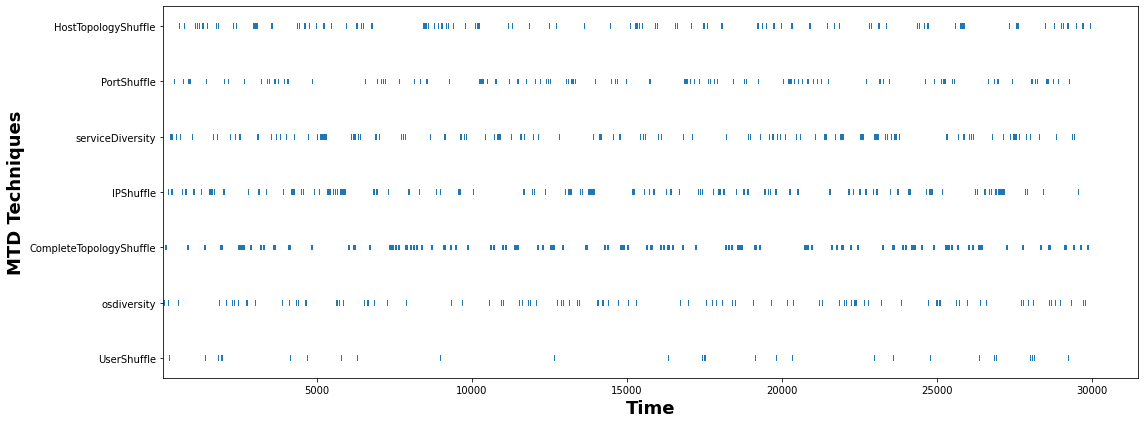

In [4]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.show()

In [5]:
attack_operation_record = pd.DataFrame(adversary.get_attack_stats().get_record())
attack_operation_record

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
0,SCAN_HOST,0.000000,5.000000,5.000000,-1,0,0,0,,[],,
1,ENUM_HOST,5.000000,7.000000,2.000000,-1,0,0,0,,[],,
2,SCAN_PORT,7.000000,17.000000,10.000000,0,1,0,0,,[],,
3,EXPLOIT_VULN,17.000000,37.703155,20.703155,0,1,0,0,,[],,
4,BRUTE_FORCE,37.703155,57.703155,20.000000,0,1,18,0,,[],,
...,...,...,...,...,...,...,...,...,...,...,...,...
2012,SCAN_PORT,15080.814496,15090.814496,10.000000,19,10,872,196,,[],,
2013,EXPLOIT_VULN,15090.814496,15110.852682,20.038186,19,10,872,196,,[],,
2014,BRUTE_FORCE,15110.852682,15130.852682,20.000000,19,10,872,196,,[],,
2015,SCAN_HOST,15130.852682,15132.107653,1.254972,19,10,872,196,,[],network,HostTopologyShuffle


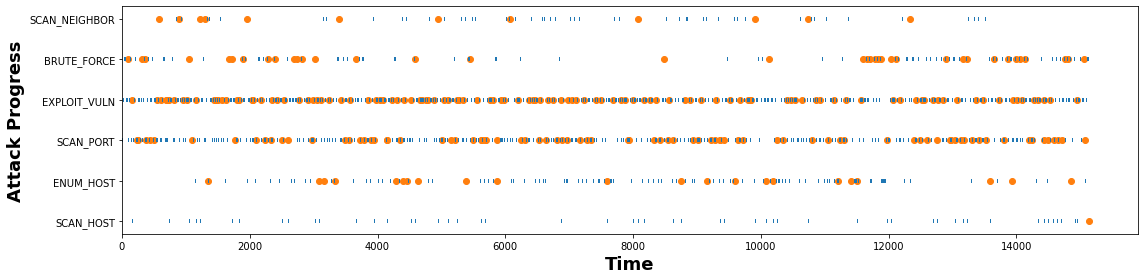

In [6]:
fig2, ax2 = plt.subplots(1, figsize=(16, 4))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1)
interrupted_record = attack_operation_record[attack_operation_record['interrupted_by'] != '']
ax2.scatter( interrupted_record['finish_time'], interrupted_record['name'])
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.show()

In [7]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
130,SCAN_PORT,1210.625573,1220.625573,10.0,30,3,234,10,30,"[Tammy, Lynnell, Ange, Zelda]",,
138,SCAN_PORT,1286.158900,1296.158900,10.0,37,1,234,11,37,"[Deeyn, Melantha, Rheta]",,
150,SCAN_PORT,1355.523554,1365.523554,10.0,35,1,250,13,35,"[Buffy, Ailina, Raina, Ricki]",,
214,SCAN_PORT,1944.924855,1954.924855,10.0,54,1,329,18,54,"[Olva, Netty, Xena]",,
391,SCAN_PORT,3392.025445,3402.025445,10.0,48,1,439,32,48,"[Gay, Ardenia]",,
535,SCAN_PORT,4468.076773,4478.076773,10.0,29,9,524,44,29,[Rhoda],,
541,SCAN_PORT,4491.076773,4501.076773,10.0,37,9,524,45,37,[Laura],,
581,SCAN_PORT,4799.311777,4809.311777,10.0,82,1,555,48,82,[Bobbette],,
610,SCAN_PORT,5036.428593,5046.428593,10.0,72,1,581,53,72,[Doralynne],,
729,SCAN_PORT,5936.449552,5946.449552,10.0,101,2,639,65,101,[],,


In [8]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
26,EXPLOIT_VULN,255.446131,275.759925,20.313794,0,3,39,0,0,"[Cam, Ruthann, Terrijo, Glad, Gussie]",,
49,EXPLOIT_VULN,506.945546,527.207956,20.262410,2,2,68,1,2,"[Myrna, Melita, Lara, Jessamine]",,
55,EXPLOIT_VULN,558.430365,582.306578,23.876214,43,1,79,2,43,"[Benoite, Riki, Rosalie, Madalyn, Drucie]",,
84,EXPLOIT_VULN,830.917594,850.964912,20.047318,20,5,119,3,20,"[Karole, Antonella, Shanon, Yoshi, Constanta]",,
88,EXPLOIT_VULN,867.964912,888.600462,20.635550,28,1,148,4,28,"[Dena, Charis, Marcile, Corinne]",,
...,...,...,...,...,...,...,...,...,...,...,...,...
1848,EXPLOIT_VULN,13431.546620,13453.261136,21.714517,13,1,862,191,13,[],,
1855,EXPLOIT_VULN,13492.125677,13513.843414,21.717737,14,1,862,192,14,[],,
1922,EXPLOIT_VULN,14201.618693,14223.502854,21.884161,16,3,862,193,16,[],,
1930,EXPLOIT_VULN,14283.657542,14303.895015,20.237473,17,1,870,194,17,[],,


In [9]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by


In [10]:
if not os.path.exists('data_analysis'):
    os.makedirs(os.path.dirname('data_analysis'))

attack_operation_record.to_csv('data_analysis/attack_operation_record.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record.csv', index=False)

In [11]:
attack_operation_record = pd.read_csv('data_analysis/attack_operation_record.csv')